# Entrenamiento y resultados
Se entrenan los modelos de gradient boosting (LightGBM) y se obtienen los resultados.




In [62]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, precision_recall_curve, confusion_matrix, classification_report
from ast import literal_eval
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Carga del dataset

In [63]:
df = pd.read_pickle("../data/orig/FraudNLP_dataset.pkl")
print("dataset shape: ", df.shape)
action_vocab = pd.read_csv("../data/orig/vocab.csv")

# one line is broken, throw it away
broken_times = df[df.times.apply(lambda x: x[-1]!="]")]
assert broken_times.shape[0] == 1
assert broken_times.iloc[0].is_fraud==0

# ignore the single broken line
df = df[df.times.apply(lambda x: x[-1]=="]")]

#build the raw text, using the names and the (index-inverted) tokens 
action_names = action_vocab.Name.to_list()
id_to_action = {str(i):a for i,a in enumerate(action_names)}
action_to_id = {a:str(i) for i,a in enumerate(action_names)}

# Recall to cast the strings into lists
df.actions = df.actions.apply(literal_eval)

df["times"] = df.times.apply(literal_eval).apply(lambda x: [i/1000 for i in x])
df["Action time mean"] = df.times.apply(np.mean)
df["Action time std"] = df.times.apply(np.std)
df["log(amount)"] = df.Amount.apply(np.log)
df["Transaction Type"] = df.is_fraud.apply(lambda x: "Fraud" if x else "Non Fraud")
df["time_to_first_action"] = df.times.apply(lambda x: x[1] if len(x)>1 else 0)
df["actions_str"] = df.actions.apply(lambda x: " ".join([id_to_action[str(i[0])] for i in x if len(i)>0]))
df["total_time_to_transaction"] = df.times.apply(sum)/1000
df['actions'] = df['actions'].apply(lambda x: [item for sublist in x for item in sublist])
df.head(2)

dataset shape:  (105303, 9)


,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud,Action time mean,Action time std,log(amount),Transaction Type,time_to_first_action,actions_str,total_time_to_transaction
1,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...","[0.0, 33.204, 215.636, 443.415, 72.586, 34.241...",203,13,1.0,1.000000,0.500000,1.0,0,177.859292,218.368580,2.564949,Non Fraud,33.204,/PROFILE/GETCUSTOMERRESPONSE /TAXFREE/GETTAXGO...,4.268623
2,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...","[0.0, 25.459, 46.236, 428.626, 42.785, 74.158,...",359,310,1.0,0.333333,0.333333,1.0,0,196.875569,252.496316,5.736572,Non Fraud,25.459,/PROFILE/GETCUSTOMERRESPONSE /CAMPAIGN/GETBALA...,587.279823


### Preprocesamiento

In [64]:
def parsear_actions(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return literal_eval(x)
        except Exception:
            # fallback: split on spaces in actions_str if present
            return []
    return []

df['actions'] = df['actions'].apply(parsear_actions)
df['is_fraud'] = df['is_fraud'].astype(int)


### Split datos: train/val/test

In [65]:
X = df.drop(columns=['is_fraud', 'log(amount)'])
y = df['is_fraud'].values
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE
)
for name, yy in [('train', y_train), ('val', y_val), ('test', y_test)]:
    print(name, len(yy), f"pos={yy.sum()} ({yy.mean():.4%})")


train 63181 pos=61 (0.0965%)
val 21060 pos=20 (0.0950%)
test 21061 pos=20 (0.0950%)


### Cargar embeddings secuenciales

In [66]:
with open('../app/modelos/encoder_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

Z_train = data['Z_train']
Z_val = data['Z_val']
Z_test = data['Z_test']

### Preparar datos tabulares

In [67]:
tab_cols_to_exclude = {'actions', 'times', 'actions_str'}  # non-tabular or sequential
tab_train = X_train.drop(columns=[c for c in tab_cols_to_exclude if c in X_train.columns], errors='ignore')
tab_val   = X_val.drop(columns=[c for c in tab_cols_to_exclude if c in X_val.columns], errors='ignore')
tab_test  = X_test.drop(columns=[c for c in tab_cols_to_exclude if c in X_test.columns], errors='ignore')

# Sólo variables numéricas
num_cols = tab_train.select_dtypes(include=[np.number]).columns.tolist()
tab_train = tab_train[num_cols].copy()
tab_val   = tab_val[num_cols].copy()
tab_test  = tab_test[num_cols].copy()

### 1) LightGBM con embeddings secuenciales

In [68]:
# Cargar embedings secuenciales
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])
X_te = np.hstack([tab_test.values,  Z_test])

# Datasets de entrenamiento y validación
lgb_train = lgb.Dataset(X_tr, label=y_train, free_raw_data=False)
lgb_val   = lgb.Dataset(X_va, label=y_val,   reference=lgb_train, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': ['average_precision', 'binary_logloss'],
    'first_metric_only': True,
    'learning_rate': 0.05,
    'num_leaves': 16,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'min_data_in_leaf': 100,
    'seed': RANDOM_STATE,
    'num_threads': -1,
}

evals_result_GBEmbeddings = {}
print("\nEntrenando LightGBM con embeddings secuenciales...")
clf_GBEmbeddings = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train","val"],
    num_boost_round=500,
    callbacks=[early_stopping(stopping_rounds=50, verbose=True), log_evaluation(period=200), lgb.record_evaluation(evals_result_GBEmbeddings)]
)
print(f"Mejor iteración: {clf_GBEmbeddings.best_iteration}")


Entrenando LightGBM con embeddings secuenciales...
[LightGBM] [Info] Number of positive: 61, number of negative: 63120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 63181, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000965 -> initscore=-6.941919
[LightGBM] [Info] Start training from score -6.941919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's average_precision: 1	train's binary_logloss: 0.000381672	val's average_precision: 0.589249	val's binary_logloss: 0.00319076
Mejor iteración: 52


### 2) LightGBM sin embedddings secuenciales

In [69]:
X_tr = np.hstack([tab_train.values])
X_va = np.hstack([tab_val.values])
X_te = np.hstack([tab_test.values])

# Datasets de entrenamiento y validación
lgb_train = lgb.Dataset(X_tr, label=y_train, free_raw_data=False)
lgb_val   = lgb.Dataset(X_va, label=y_val,   reference=lgb_train, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': ['average_precision', 'binary_logloss'],
    'first_metric_only': True,
    'learning_rate': 0.05,
    'num_leaves': 16,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'min_data_in_leaf': 100,
    'seed': RANDOM_STATE,
    'num_threads': -1,
}

evals_result_GB = {}
print("\nEntrenando LightGBM...")
clf_GB = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train","val"],
    num_boost_round=5000,
    callbacks=[early_stopping(stopping_rounds=50, verbose=True), log_evaluation(period=200), lgb.record_evaluation(evals_result_GB)]
)
print(f"Mejor iteración: {clf_GB.best_iteration}")


Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 61, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 63181, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000965 -> initscore=-6.941919
[LightGBM] [Info] Start training from score -6.941919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's average_precision: 0.999467	train's binary_logloss: 0.000767831	val's average_precision: 0.374186	val's binary_logloss: 0.00410175
Mejor iteración: 72


### 3) LightGBM sin embedddings secuenciales pero con SMOTE

In [70]:
X_tr = np.hstack([tab_train.values])
X_va = np.hstack([tab_val.values])
X_te = np.hstack([tab_test.values])

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_tr_resampled, y_train_resampled = smote.fit_resample(X_tr, y_train)

lgb_train = lgb.Dataset(X_tr_resampled, label=y_train_resampled, free_raw_data=False)
lgb_val   = lgb.Dataset(X_va, label=y_val,   reference=lgb_train, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': ['average_precision', 'binary_logloss'],
    'learning_rate': 0.05,
    'num_leaves': 16,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'min_data_in_leaf': 100,
    'seed': RANDOM_STATE,
    'num_threads': -1,
}

evals_result_GBSMOTE = {}
print("\nEntrenando LightGBM con SMOTE...")
clf_GBSMOTE = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train","val"],
    num_boost_round=250,
    callbacks=[early_stopping(stopping_rounds=50, verbose=True), log_evaluation(period=200), lgb.record_evaluation(evals_result_GBSMOTE)],
)
print(f"Mejor iteración: {clf_GBSMOTE.best_iteration}")


Entrenando LightGBM con SMOTE...
[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 126240, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	train's average_precision: 0.999648	train's binary_logloss: 0.0203777	val's average_precision: 0.341155	val's binary_logloss: 0.0310766
Mejor iteración: 99


### 4) LightGBM con embeddings secuenciales + SMOTE

In [71]:
# Cargar embedings secuenciales
X_tr = np.hstack([tab_train.values, Z_train])
X_va = np.hstack([tab_val.values,   Z_val])
X_te = np.hstack([tab_test.values,  Z_test])

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_tr_resampled, y_train_resampled = smote.fit_resample(X_tr, y_train)

# Datasets de entrenamiento y validación
lgb_train = lgb.Dataset(X_tr_resampled, label=y_train_resampled, free_raw_data=False)
lgb_val   = lgb.Dataset(X_va, label=y_val,   reference=lgb_train, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': ['average_precision', 'binary_logloss'],
    'first_metric_only': True,
    'learning_rate': 0.05,
    'num_leaves': 16,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'min_data_in_leaf': 100,
    'seed': RANDOM_STATE,
    'num_threads': -1,
}

evals_result_GBEmbeddingsSMOTE = {}
print("\nEntrenando LightGBM con embeddings secuenciales...")
clf_GBEmbeddingsSMOTE = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train","val"],
    num_boost_round=5000,
    callbacks=[early_stopping(stopping_rounds=50, verbose=True), log_evaluation(period=200), lgb.record_evaluation(evals_result_GBEmbeddingsSMOTE)]
)
print(f"Mejor iteración: {clf_GBEmbeddingsSMOTE.best_iteration}")


Entrenando LightGBM con embeddings secuenciales...
[LightGBM] [Info] Number of positive: 63120, number of negative: 63120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35190
[LightGBM] [Info] Number of data points in the train set: 126240, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	train's average_precision: 0.999914	train's binary_logloss: 0.00693	val's average_precision: 0.576321	val's binary_logloss: 0.0103217
Mejor iteración: 94


### Guardar modelos y resultados

In [72]:
data = {
    'evals_result_GBEmbeddings': evals_result_GBEmbeddings,
    'evals_result_GB': evals_result_GB,
    'evals_result_GBSMOTE': evals_result_GBSMOTE,
    'evals_result_GBEmbeddingsSMOTE': evals_result_GBEmbeddingsSMOTE,
    'clf_GBEmbeddings': clf_GBEmbeddings,
    'clf_GB': clf_GB,
    'clf_GBSMOTE': clf_GBSMOTE,
    'clf_GBEmbeddingsSMOTE': clf_GBEmbeddingsSMOTE,
}

# Guardar en pickle
with open('../app/modelos/modelos_lightgbm.pkl', 'wb') as f:
    pickle.dump(data, f)

### Entrenamiento vs validación (PR-AUC)

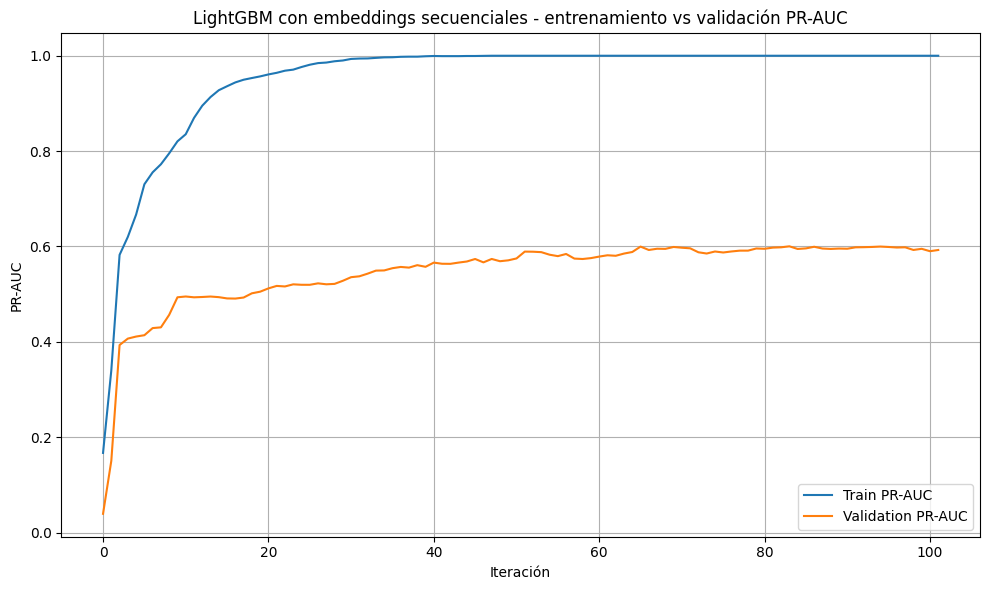

In [73]:
train_metric = evals_result_GBEmbeddings['train']['average_precision']
val_metric = evals_result_GBEmbeddings['val']['average_precision']

plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train PR-AUC')
plt.plot(val_metric, label='Validation PR-AUC')
plt.xlabel('Iteración')
plt.ylabel('PR-AUC')
plt.title('LightGBM con embeddings secuenciales - entrenamiento vs validación PR-AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEmbeddings_train_vs_validation.png", dpi=180, bbox_inches="tight")
plt.show()

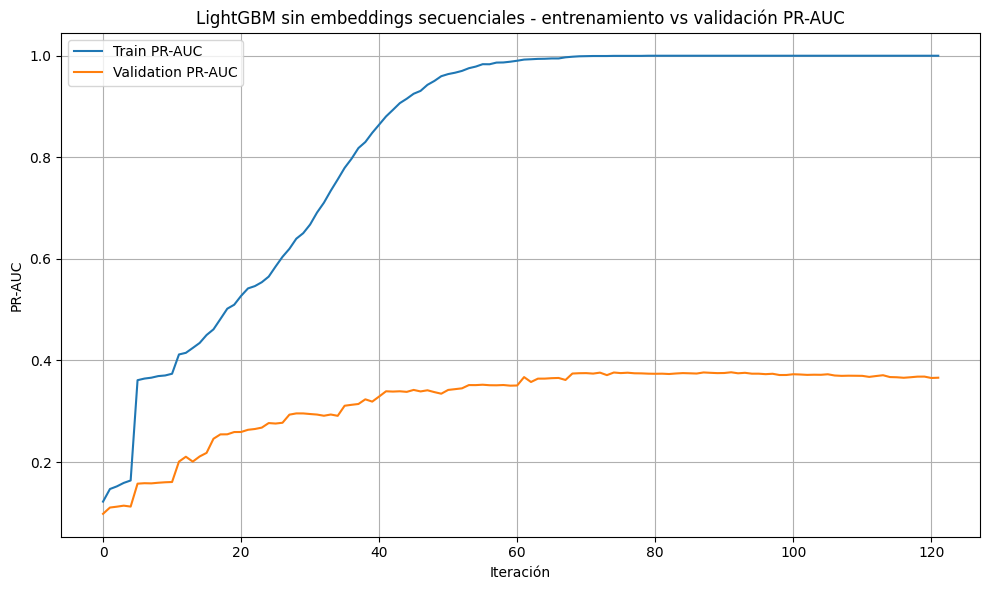

In [74]:
train_metric = evals_result_GB['train']['average_precision']
val_metric = evals_result_GB['val']['average_precision']

plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train PR-AUC')
plt.plot(val_metric, label='Validation PR-AUC')
plt.xlabel('Iteración')
plt.ylabel('PR-AUC')
plt.title('LightGBM sin embeddings secuenciales - entrenamiento vs validación PR-AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GB_train_vs_validation.png", dpi=180, bbox_inches="tight")
plt.show()

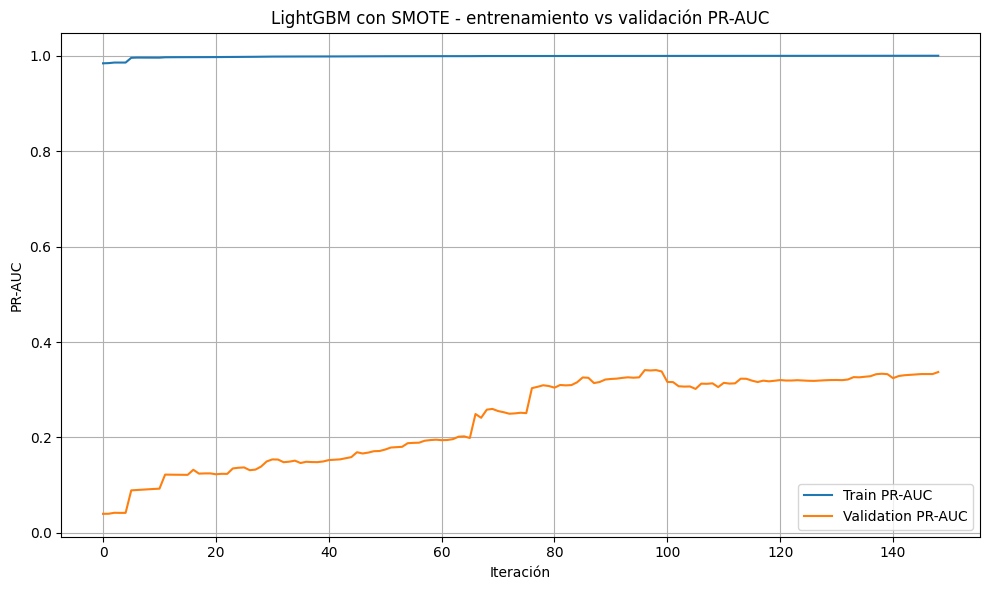

In [75]:
train_metric = evals_result_GBSMOTE['train']['average_precision']
val_metric = evals_result_GBSMOTE['val']['average_precision']

plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train PR-AUC')
plt.plot(val_metric, label='Validation PR-AUC')
plt.xlabel('Iteración')
plt.ylabel('PR-AUC')
plt.title('LightGBM con SMOTE - entrenamiento vs validación PR-AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GBSMOTE_train_vs_validation.png", dpi=180, bbox_inches="tight")
plt.show()

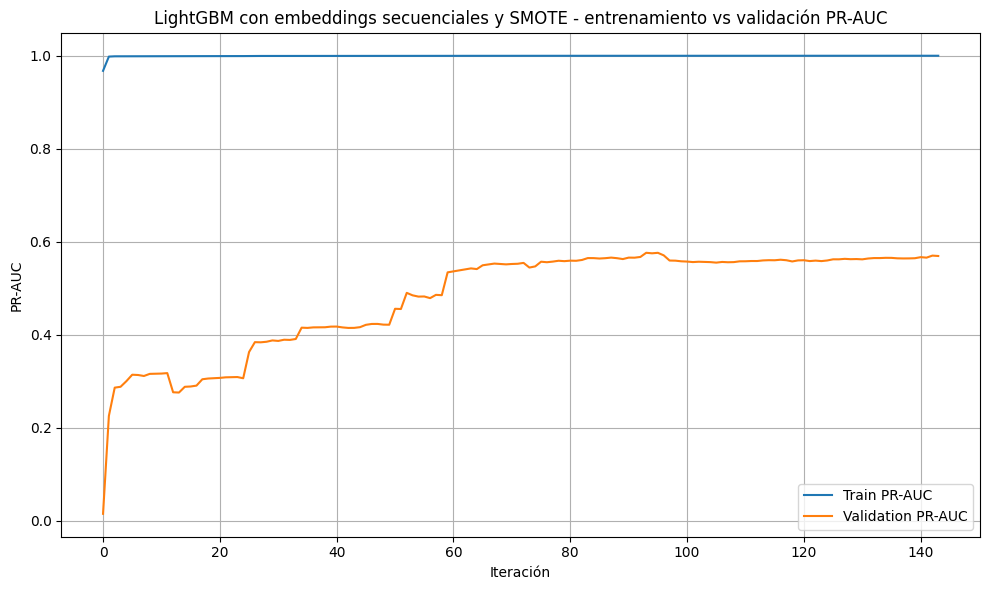

In [76]:
train_metric = evals_result_GBEmbeddingsSMOTE['train']['average_precision']
val_metric = evals_result_GBEmbeddingsSMOTE['val']['average_precision']

plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train PR-AUC')
plt.plot(val_metric, label='Validation PR-AUC')
plt.xlabel('Iteración')
plt.ylabel('PR-AUC')
plt.title('LightGBM con embeddings secuenciales y SMOTE - entrenamiento vs validación PR-AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEmbeddingsSMOTE_train_vs_validation.png", dpi=180, bbox_inches="tight")
plt.show()

#### Parece que SMOTE tiene a introducir ruido.

### Gráficas binary logloss

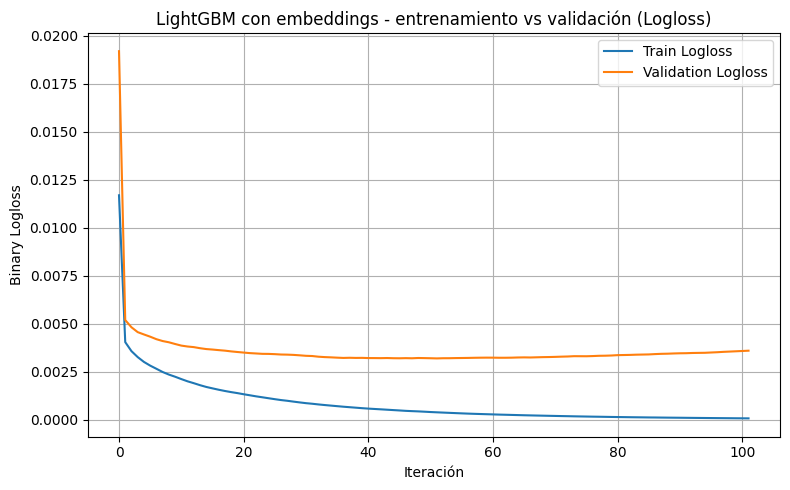

In [77]:
train_logloss = evals_result_GBEmbeddings["train"]["binary_logloss"]
val_logloss   = evals_result_GBEmbeddings["val"]["binary_logloss"]

plt.figure(figsize=(8,5))
plt.plot(train_logloss, label="Train Logloss")
plt.plot(val_logloss, label="Validation Logloss")
plt.xlabel("Iteración")
plt.ylabel("Binary Logloss")
plt.title("LightGBM con embeddings - entrenamiento vs validación (Logloss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEmbeddings_logloss.png", dpi=180, bbox_inches="tight")
plt.show()

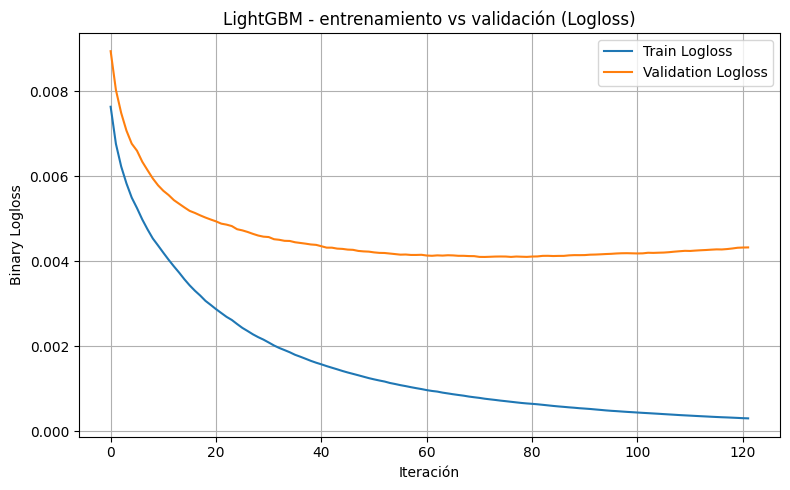

In [78]:
train_logloss = evals_result_GB["train"]["binary_logloss"]
val_logloss   = evals_result_GB["val"]["binary_logloss"]

plt.figure(figsize=(8,5))
plt.plot(train_logloss, label="Train Logloss")
plt.plot(val_logloss, label="Validation Logloss")
plt.xlabel("Iteración")
plt.ylabel("Binary Logloss")
plt.title("LightGBM - entrenamiento vs validación (Logloss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GB_logloss.png", dpi=180, bbox_inches="tight")
plt.show()

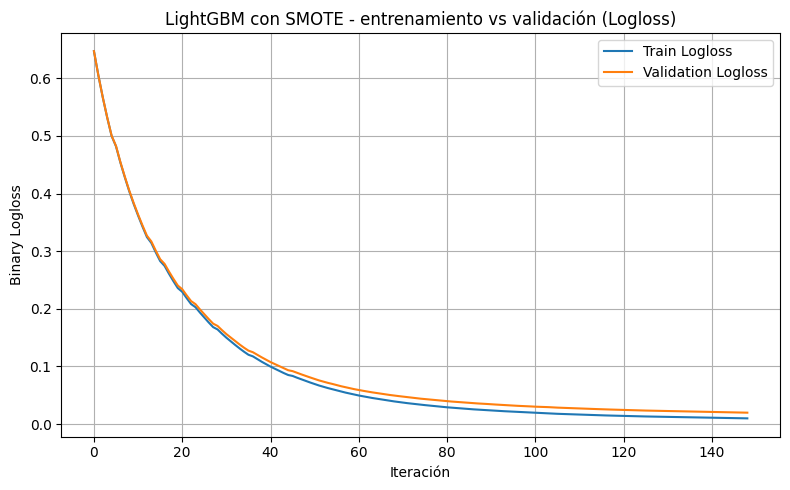

In [79]:
train_logloss = evals_result_GBSMOTE["train"]["binary_logloss"]
val_logloss   = evals_result_GBSMOTE["val"]["binary_logloss"]

plt.figure(figsize=(8,5))
plt.plot(train_logloss, label="Train Logloss")
plt.plot(val_logloss, label="Validation Logloss")
plt.xlabel("Iteración")
plt.ylabel("Binary Logloss")
plt.title("LightGBM con SMOTE - entrenamiento vs validación (Logloss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GBSMOTE_logloss.png", dpi=180, bbox_inches="tight")
plt.show()

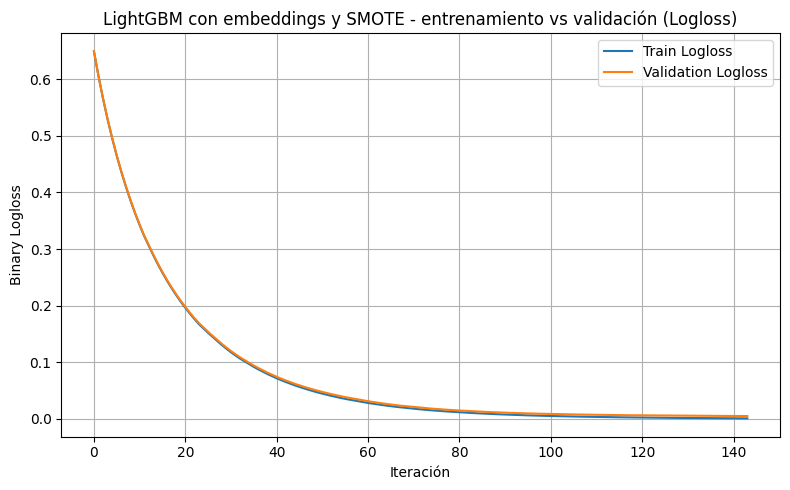

In [80]:
train_logloss = evals_result_GBEmbeddingsSMOTE["train"]["binary_logloss"]
val_logloss   = evals_result_GBEmbeddingsSMOTE["val"]["binary_logloss"]

plt.figure(figsize=(8,5))
plt.plot(train_logloss, label="Train Logloss")
plt.plot(val_logloss, label="Validation Logloss")
plt.xlabel("Iteración")
plt.ylabel("Binary Logloss")
plt.title("LightGBM con embeddings y SMOTE - entrenamiento vs validación (Logloss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../informes/figuras/GBEmbeddingsSMOTE_logloss.png", dpi=180, bbox_inches="tight")
plt.show()